# Computing and Plotting Power Spectra

In this tutorial, we cover how to compute and plot power spectra with `tuesday`.
Here we will focus on computing these quantities use the `core` interface, which is
a generic interface that can be used for most simulator outputs. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as un

%matplotlib inline

import powerbox as pb

import tuesday

## Calculating Power Spectra From Coeval Boxes

Coeval boxes are cubes of some physical field at a particular redshift, generally 
constructed using a simulator. For this tutorial we don't worry about which simulator
has produced the data, and instead just focus on how to compute the power spectrum 
(both cylindrically and spherically averaged) and plot it with `tuesday`. 
 
To construct a mock "coeval cube" for the sake of illustration, we will use `powerbox`:

In [2]:
delta_x = (
    pb.PowerBox(
        N=32,  # Number of grid-points in the box
        dim=3,  # 3D box
        pk=lambda k: 0.1 * k**-2.0,  # The power-spectrum
        boxlength=200.0,  # Size of the box (sets the units of k in pk)
        seed=1010,  # Set a seed to ensure the box looks the same every time (optional)
    ).delta_x()
    * un.dimensionless_unscaled
)
box_len = 200.0 * un.Mpc

The `delta_x` we just constructed is a 3D numpy array (in this case, it contains the 
over-densities of a Gaussian Random Field with a power spectrum of $0.1 * k^{-2}$):

In [3]:
print(f"Type: {type(delta_x)}\nShape: {delta_x.shape}\nMean: {np.mean(delta_x):.3f}")

Type: <class 'astropy.units.quantity.Quantity'>
Shape: (32, 32, 32)
Mean: 0.000


We can use `tuesday` to plot coeval slices from this cube:

In [4]:
from tuesday.core import (
    coeval2slice_x,
    coeval2slice_y,
    coeval2slice_z,
    plot_coeval_slice,
)

We first slice along the x-axis and plot:

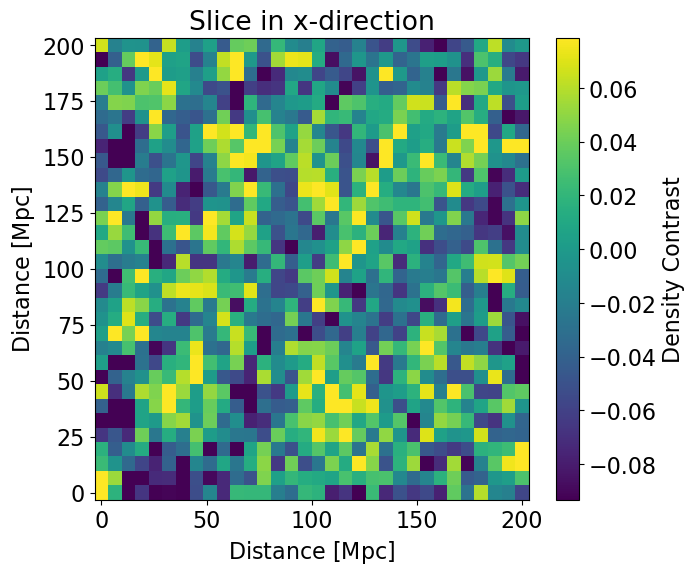

In [5]:
ax = plot_coeval_slice(
    delta_x,
    box_len,
    transform2slice=coeval2slice_x(idx=15),
    title="Slice in x-direction",
)

We can also include a velocity field on top of the slice plot:

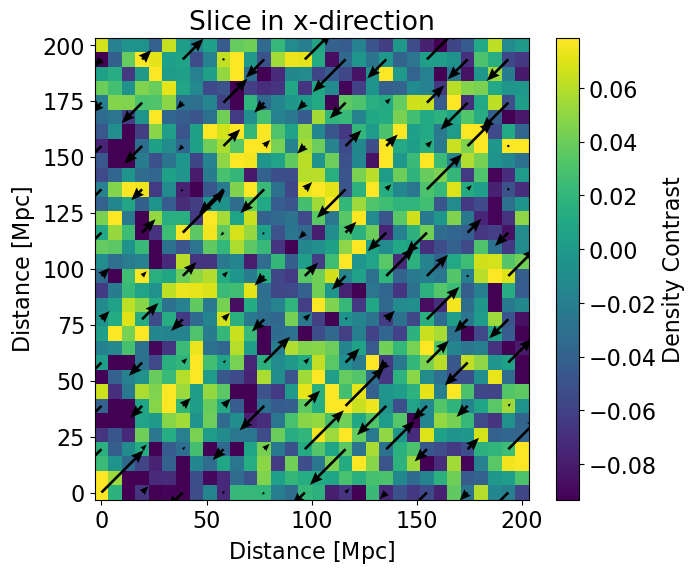

In [6]:
ax = plot_coeval_slice(
    delta_x,
    box_len,
    transform2slice=coeval2slice_x(idx=15),
    title="Slice in x-direction",
    v_x=delta_x[15, ...] * un.m / un.s,
    v_y=delta_x[15, ...] * un.m / un.s,
    quiver_decimate_factor=3,
)

Slice along the y direction and pretending we're passing a brightness temperature in mK:

<Axes: title={'center': 'Slice in y-direction'}, xlabel='Distance [$\\mathrm{Mpc}$]', ylabel='Distance [$\\mathrm{Mpc}$]'>

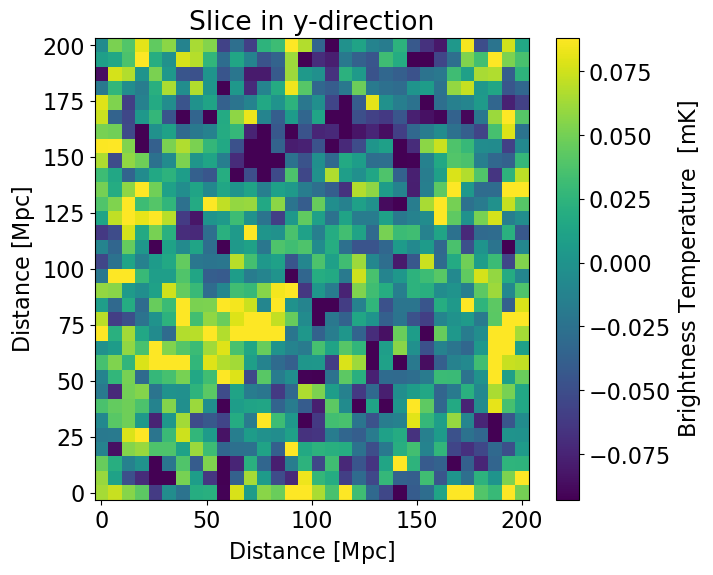

In [7]:
plot_coeval_slice(
    delta_x.value * un.mK,
    box_len,
    transform2slice=coeval2slice_y(),
    title="Slice in y-direction",
)

And finally, slice along the z-axis:

<Axes: title={'center': 'Slice in z-direction'}, xlabel='Distance [$\\mathrm{Mpc}$]', ylabel='Distance [$\\mathrm{Mpc}$]'>

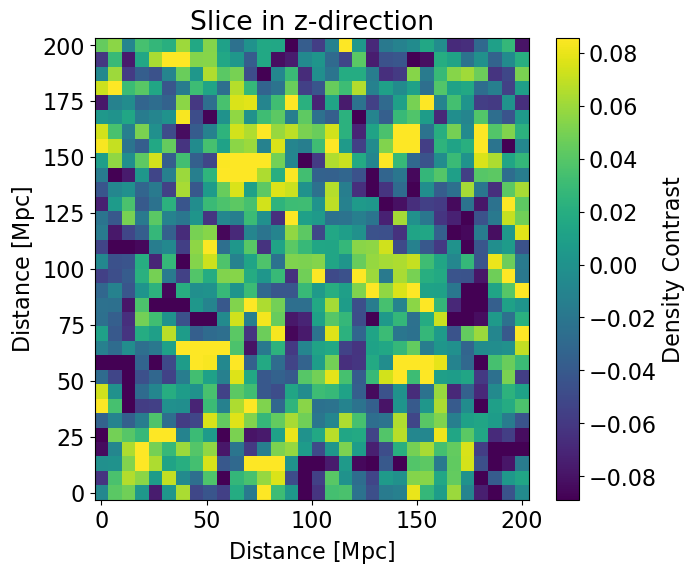

In [8]:
plot_coeval_slice(
    delta_x,
    box_len,
    transform2slice=coeval2slice_z(idx=5),
    title="Slice in z-direction",
)

We calculate the power spectrum of this field using the `tuesday` function `calculate_ps_coeval`:

In [9]:
delta_x.shape

(32, 32, 32)

In [10]:
ps1d, ps2d = tuesday.core.calculate_ps_coeval(
    delta_x,
    box_length=box_len,
    calc_2d=True,
    calc_1d=True,
    deltasq=False,
)

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:287: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:732: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:551: RuntimeWarning: invalid value encountered in divide
  np.bincount(


The return values from `calculate_ps_coeval` are both the 1D and 2D power spectra (if
`calc_1d` or `calc_2d` is set to False, then that return value is None). Each of these
is a simple object containing relevant power spectrum information:

In [11]:
print(ps1d)

SphericalPS(ps=<Quantity [        nan,         nan, 13.61492852,         nan, 23.1804172 ,
           10.04827448,  6.78482437,  5.82474082,  3.62491243,  2.1361867 ,
            1.64325999,  1.02831267,  0.70031669,  0.4669579 ] Mpc3>, k=<Quantity [       nan,        nan, 0.05441398,        nan, 0.07695299,
           0.09424778, 0.11266983, 0.13917367, 0.17177185, 0.2084794 ,
           0.25500155, 0.31087616, 0.3774645 , 0.46009438] 1 / Mpc>, redshift=None, n_modes=array([   0.,    0.,    8.,    0.,   24.,   24.,   80.,  144.,  320.,
        512., 1160., 1904., 3728., 6880.]), variance=None, is_deltasq=False)


Having the power spectrum in this form makes it easier to plot with the core functions
in `tuesday`. The power spectrum plotting functions in `tuesday` require such a power spectrum
object, which is very easy to create. Let's create a mock SphericalPS containing
the analytical power spectrum we used to construct the box:

In [12]:
ps1d_analytic = tuesday.core.SphericalPS(
    k=ps1d.k,
    ps=(ps1d.k * un.Mpc) ** -2.0 * (0.1 * ps1d.ps.unit),
)

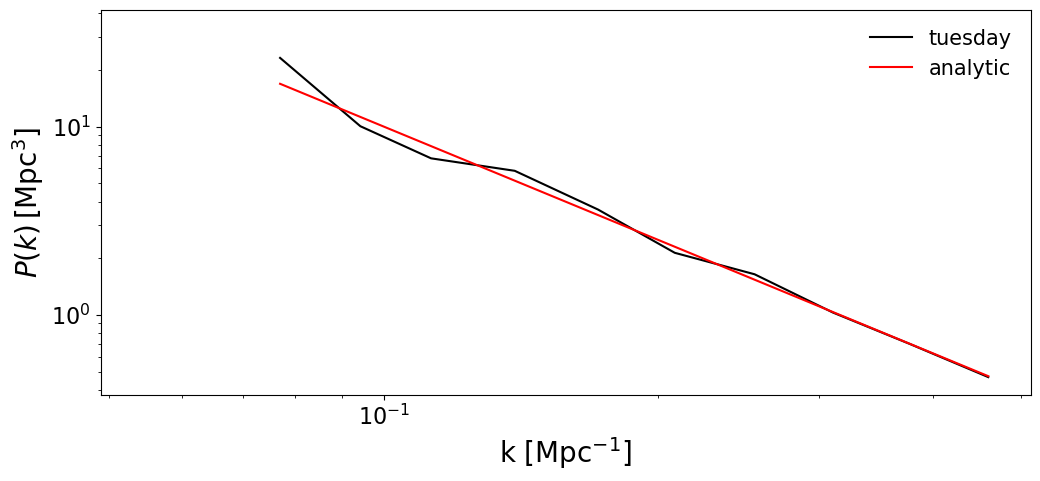

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax = tuesday.core.plot_power_spectrum(
    ps1d,
    fontsize=20,
    ax=ax,
    color="k",
    legend="tuesday",
    logx=True,
    logy=True,
)
ax = tuesday.core.plot_power_spectrum(
    ps1d_analytic,
    fontsize=20,
    ax=ax,
    color="r",
    legend="analytic",
    legend_kwargs={"loc": "upper right", "frameon": False, "fontsize": 15},
    logx=True,
    logy=True,
)

We can also plot the 2D power spectrum:

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:1896: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)


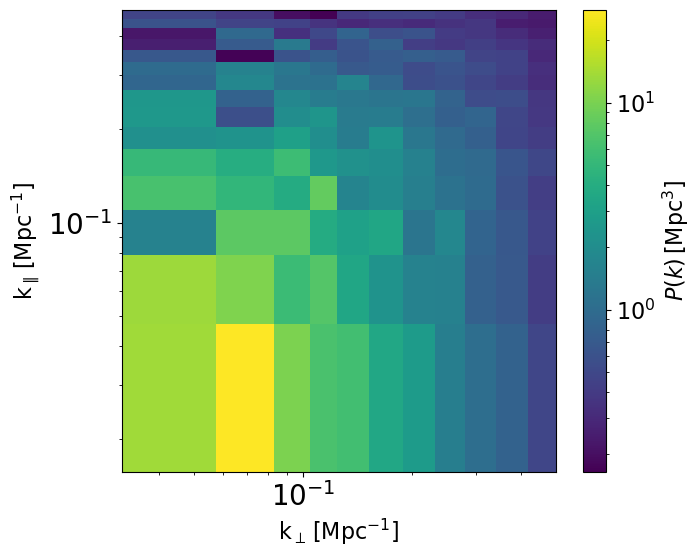

In [14]:
ax = tuesday.core.plot_power_spectrum(
    ps2d,
    logx=True,
    logy=True,
    logc=True,
)

## Calculating Power Spectra from Lightcones

Lightcones are cuboids of some physical field consisting of many 2D slices at different
redshifts. Throughout `tuesday`, lightcones are represented as 3D numpy arrays in which
the line-of-sight (or redshift) axis is the *last* axis of the array.

For this example, we're going to be agnostic about where the lightcone was actually made,
and instead make a "mock" lightcone consisting of a series of random 'coeval' boxes 
(that we just made above) stitched together over their last axis. 

In [15]:
lc = np.zeros((32, 32, 32 * 10))
rng = np.random.default_rng(42)

for i in range(10):
    lc[:, :, i * 32 : (i + 1) * 32] = pb.PowerBox(
        N=32,  # Number of grid-points in the box
        dim=3,  # 3D box
        pk=lambda k: (i + 1) * 0.1 * k**-2.0,  # noqa: B023
        boxlength=200.0,  # Size of the box (sets the units of k in pk)
        seed=rng.integers(
            0, 10000, 1
        ),  # Set a seed to ensure the box looks the same every time (optional)
    ).delta_x()
lc = lc * un.dimensionless_unscaled

Let's pretend this lightcone spans redshifts 6 to 35. We define the redshift of each
slice:

In [16]:
lc_redshifts = np.linspace(6, 35, lc.shape[-1])

We can also use `tuesday` to plot lightcone slices:

In [ ]:
from tuesday.core import lc2slice_x, lc2slice_y, plot_lightcone_slice

<Axes: title={'center': 'Slice in x-direction'}, xlabel='Redshift', ylabel='Distance [$\\mathrm{Mpc}$]'>

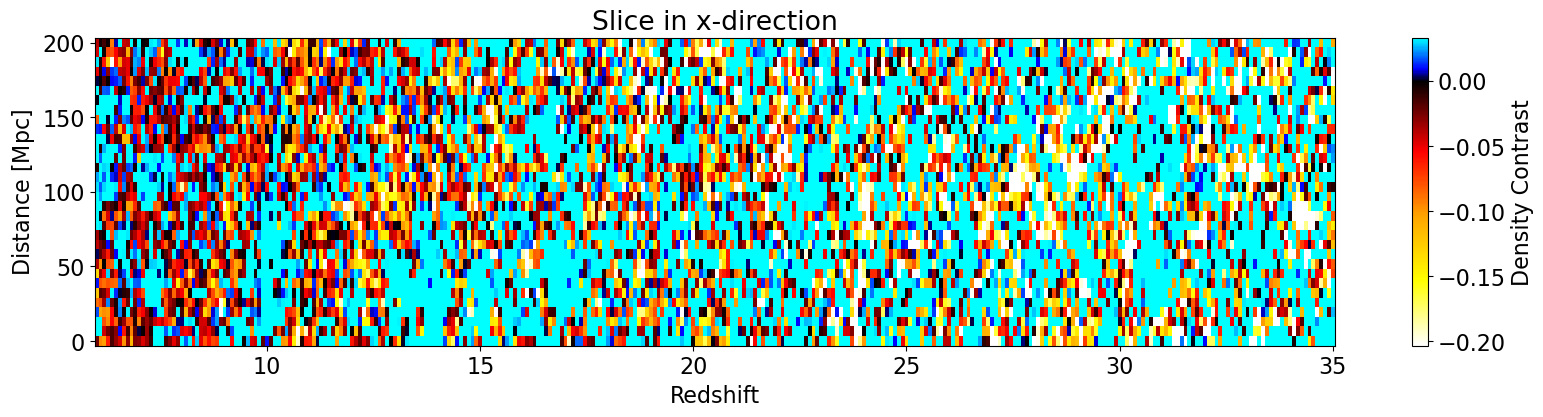

In [ ]:
plot_lightcone_slice(
    lc,
    box_len,
    lc_redshifts,
    transform2slice=lc2slice_x(idx=15),
    title="Slice in x-direction",
)

The default colormap forces 0 to be black (which makes sense for lightcones). 
However, since we're dealing with test data here, we can set the colorbar range manually via `vmin` and `vmax`:

<Axes: title={'center': 'Slice in x-direction'}, xlabel='Redshift', ylabel='Distance [$\\mathrm{Mpc}$]'>

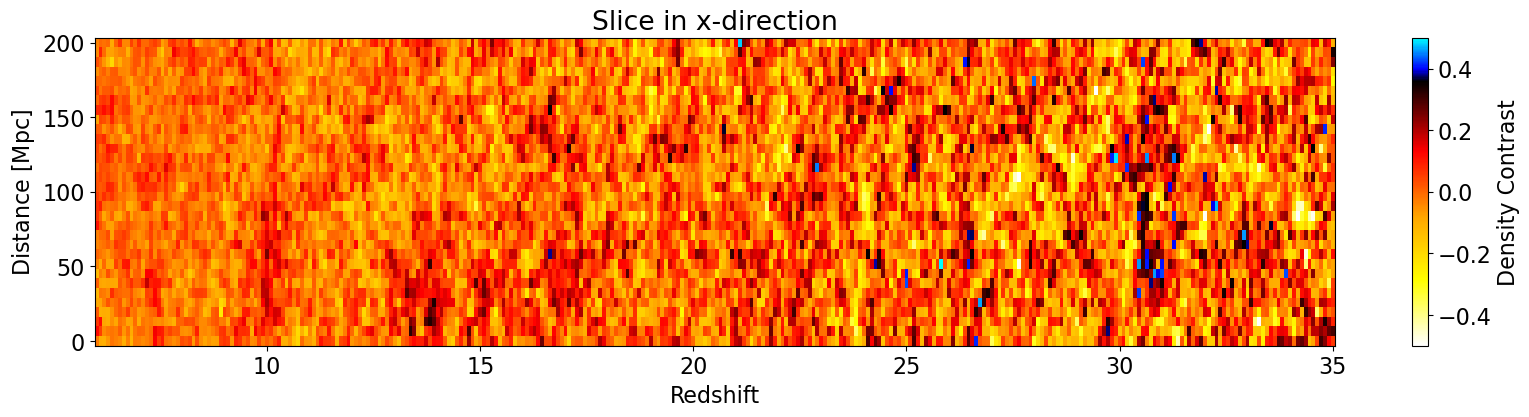

In [ ]:
plot_lightcone_slice(
    lc,
    box_len,
    lc_redshifts,
    transform2slice=lc2slice_x(idx=15),
    title="Slice in x-direction",
    vmin=-0.5,
    vmax=0.5,
)

Finally, let's also check the lightcone if we take a slice along the y-axis instead:

<Axes: title={'center': 'Slice in y-direction'}, xlabel='Redshift', ylabel='Distance [$\\mathrm{Mpc}$]'>

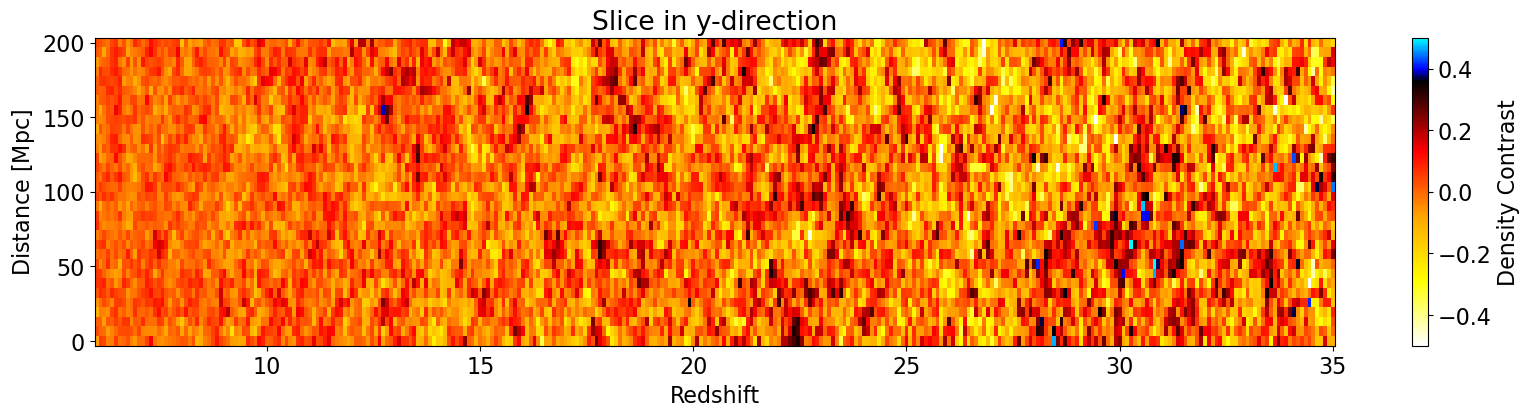

In [ ]:
plot_lightcone_slice(
    lc,
    box_len,
    lc_redshifts,
    transform2slice=lc2slice_y(idx=15),
    title="Slice in y-direction",
    vmin=-0.5,
    vmax=0.5,
)

To calculate the power spectrum of the lightcone, we use the `calculate_ps_lightcone` function,
which has a key difference compared to `calculate_ps_coeval`, in that it can split the 
lightcone into multiple 'chunks' along the line-of-sight (redshift) axis, and computes
the power spectrum of each chunk separately. This is usually what is desired from 
a lightcone, where spectra are calculated in smaller chunks that approximate the 
underlying spectrum at a particular redshift. 

You have control over the redshifts at the centre of each chunk, and how large the chunk
is (in terms of number of slices). By default the chunk size is chosen to yield cubic
chunks (i.e. the same number of chunks in the line-of-sight as there are pixels in the 
transverse dimensions).

In [21]:
# We compute the power spectrum at the central redshift of each mock "ceoval"
# that we stitched together.
ps_redshifts = lc_redshifts[16::32]
ps1d, ps2d = tuesday.core.calculate_ps_lc(
    lc * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    lc_redshifts=lc_redshifts,
    ps_redshifts=ps_redshifts,
    calc_2d=True,
    calc_1d=True,
    deltasq=False,
)

Now the outputs are both lists containing multiple `SphericalPS` and `CylindricalPS` instances, respectively. 
Each of these PS corresponds to one of the redshift chunks we defined above.

Let's use the same plotting function we used above to plot the spherically-averaged
power spectrum of each chunk, along with the analytic input:

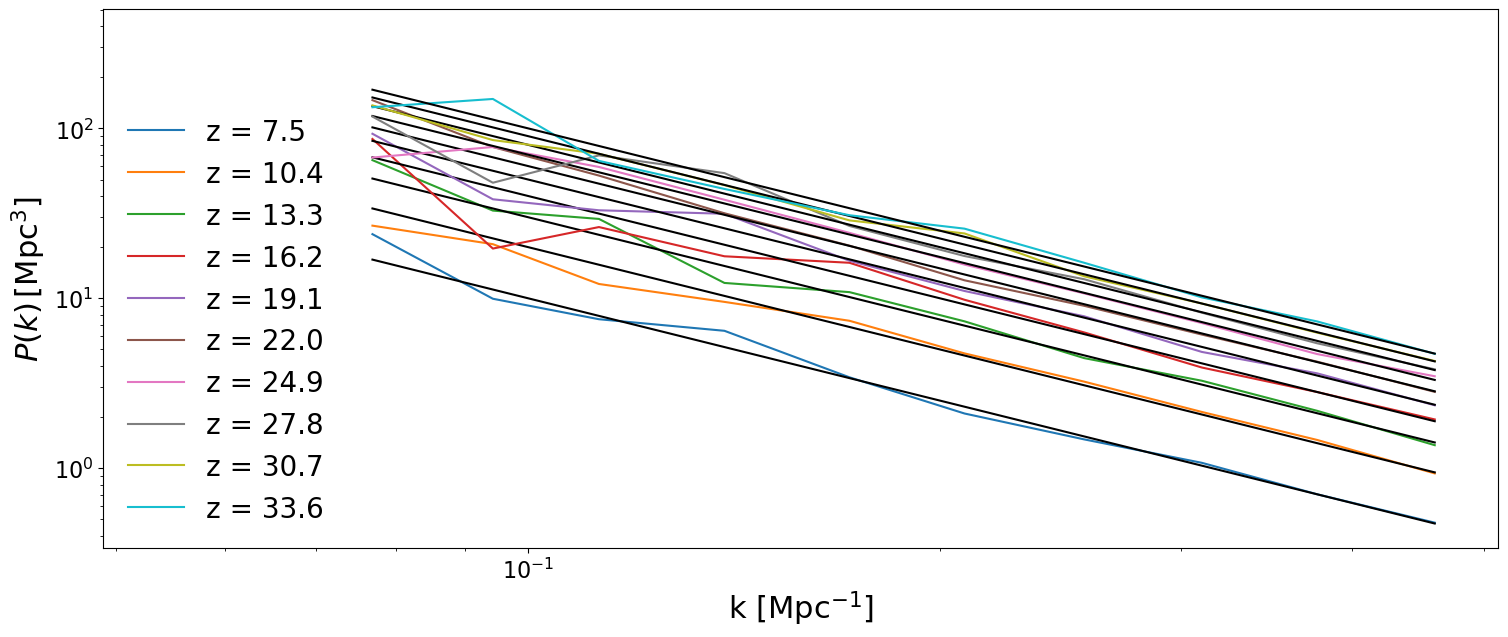

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(18, 7))
all_analytic = []
for i, (z, ps) in enumerate(zip(ps_redshifts, ps1d, strict=False)):
    ax = tuesday.core.plot_power_spectrum(
        ps,
        fontsize=20,
        ax=ax,
        color=f"C{i}",
        legend=f"z = {z:.1f}",
        legend_kwargs={"frameon": False},
        logx=True,
        logy=True,
    )
    analytic = tuesday.core.SphericalPS(
        ps=(i + 1) * 0.1 * ps.k.value**-2.0 * ps.ps.unit,
        k=ps.k,
        redshift=z,
    )
    all_analytic.append(analytic)
    ax = tuesday.core.plot_power_spectrum(
        analytic,
        fontsize=22,
        ax=ax,
        color="k",
        legend=None,
        legend_kwargs=None,
        logx=True,
        logy=True,
    )

We can also plot the PS vs redshift for a given $k$ bin via the `at_k` argument by supplying multiple `SphericalPS` instances at once. The `at_k` argument can take an `int` that corresponds to the k-bin index you want to plot. Otherwise, it can take a `float`, which corresponds to the $k$ value you want in the same units as the wavemodes supplied to the `SphericalPS` instances. If you supply multiple `SphericalPS` instances, but not `at_k`, then it automatically plots the first $k$ bin that is not NaN:

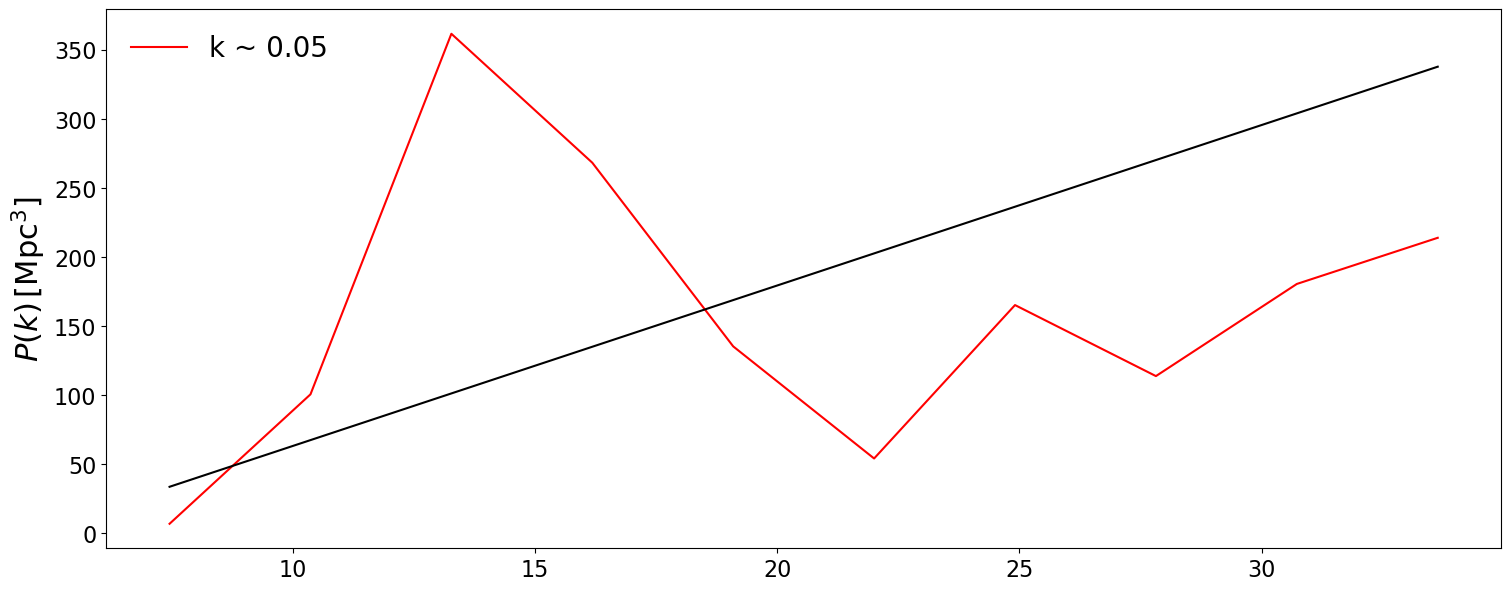

In [31]:
# Not supplying at_k will plot the first k-bin that is not NaN:
fig, ax = plt.subplots(1, 1, figsize=(18, 7))

ax = tuesday.core.plot_power_spectrum(
    ps1d,
    at_k=0.05,
    fontsize=20,
    ax=ax,
    color="r",
    legend="k ~ 0.05",
    legend_kwargs={"frameon": False},
    logx=False,
    logy=False,
)

ax = tuesday.core.plot_power_spectrum(
    all_analytic,
    at_k=0.05,
    fontsize=22,
    ax=ax,
    color="k",
    legend=None,
    legend_kwargs=None,
    logx=False,
    logy=False,
)
plt.show()

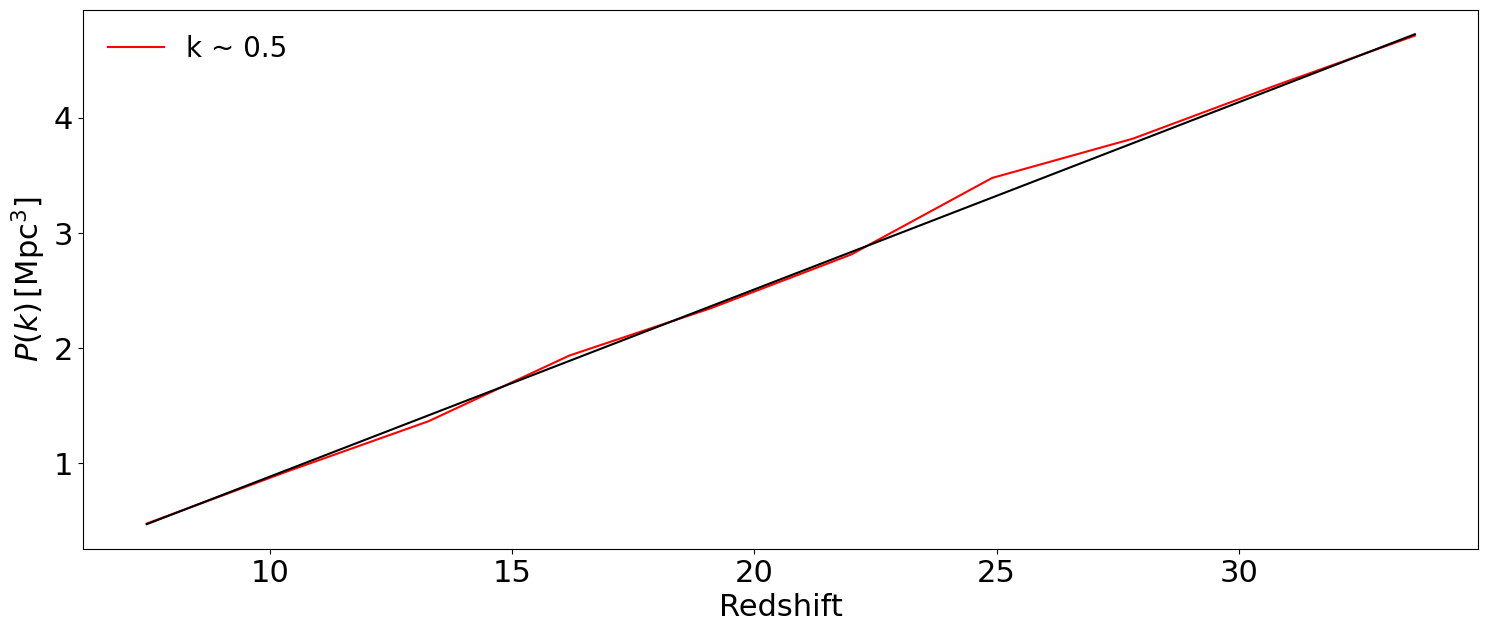

In [ ]:
# Must supply the k-bin value you want to plot with at_k:
at_k = 0.5
fig, ax = plt.subplots(1, 1, figsize=(18, 7))

ax = tuesday.core.plot_power_spectrum(
    ps1d,
    fontsize=20,
    ax=ax,
    color="r",
    at_k=at_k,
    legend="k ~ " + str(at_k),
    legend_kwargs={"frameon": False},
    logx=False,
    logy=False,
)

ax = tuesday.core.plot_power_spectrum(
    all_analytic,
    fontsize=22,
    ax=ax,
    color="k",
    at_k=at_k,
    legend=None,
    legend_kwargs=None,
    logx=False,
    logy=False,
)
plt.show()

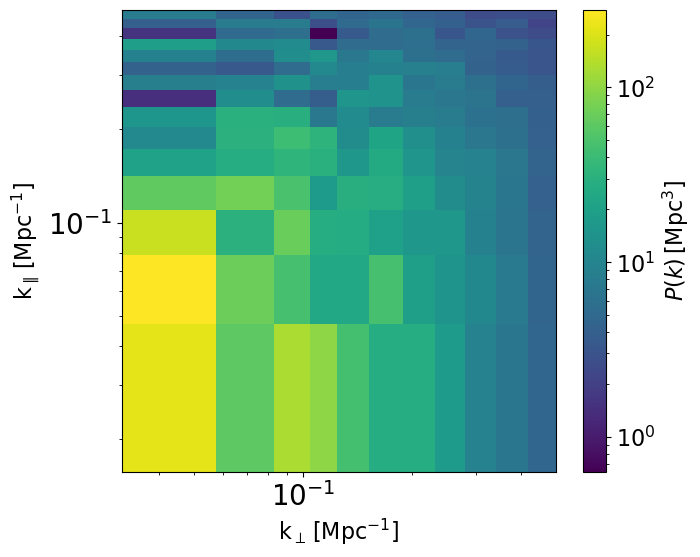

In [24]:
ax = tuesday.core.plot_power_spectrum(
    ps2d[-1],
    logx=True,
    logy=True,
    logc=True,
)

We can also rebin this 2D PS to have log bins in kpar as well:

In [25]:
ps1d, ps2d = tuesday.core.calculate_ps_lc(
    lc * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    lc_redshifts=lc_redshifts,
    ps_redshifts=ps_redshifts,
    calc_2d=True,
    calc_1d=False,
    deltasq=False,
    transform_ps2d=tuesday.core.bin_kpar(
        bins_kpar=10, log_kpar=True, interp_kpar=False
    ),
)

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/tuesday/core/summaries/powerspectra.py:717: RuntimeWarning: Mean of empty slice
  final_ps[..., i] = np.nanmean(ps.ps.value[..., m], axis=-1)


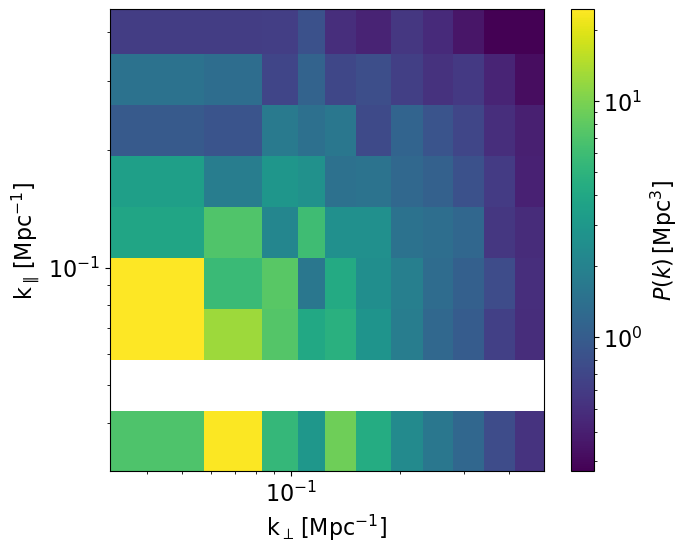

In [26]:
ax = tuesday.core.plot_power_spectrum(
    ps2d[0],
    logx=True,
    logy=True,
    logc=True,
)

We can crop some of the empty bins:

In [27]:
ps1d, ps2d = tuesday.core.calculate_ps_lc(
    lc * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    lc_redshifts=lc_redshifts,
    ps_redshifts=ps_redshifts,
    calc_2d=True,
    calc_1d=True,
    deltasq=False,
    transform_ps2d=tuesday.core.bin_kpar(
        bins_kpar=10, log_kpar=True, interp_kpar=False, crop_kpar=(4, 11)
    ),
)

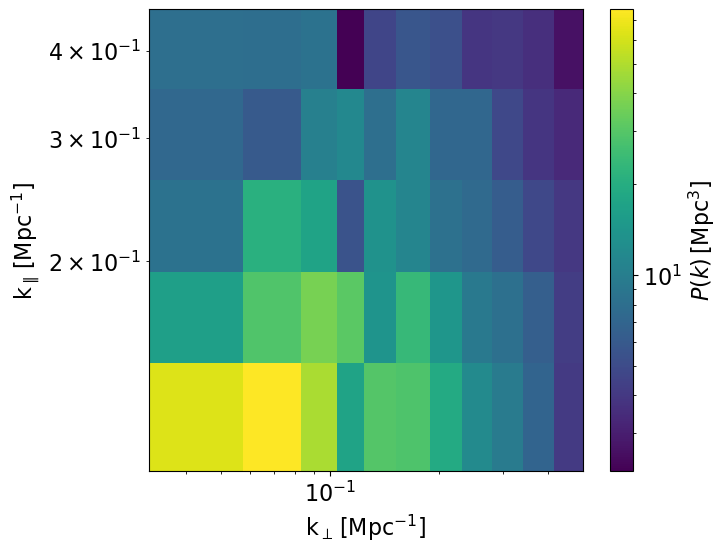

In [28]:
ax = tuesday.core.plot_power_spectrum(
    ps2d[-1],
    logx=True,
    logy=True,
    logc=True,
)

If we don't interpolate, we end up with many empty bins in kpar!
Let's try interpolating:

In [29]:
ps1d, ps2d = tuesday.core.calculate_ps_lc(
    lc * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    lc_redshifts=lc_redshifts,
    ps_redshifts=ps_redshifts,
    calc_2d=True,
    calc_1d=True,
    deltasq=None,
    transform_ps2d=tuesday.core.bin_kpar(bins_kpar=10, log_kpar=True, interp_kpar=True),
)

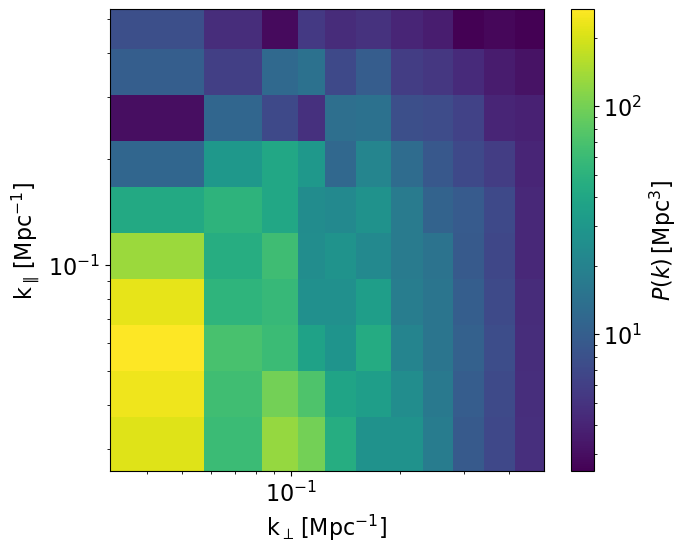

In [30]:
ax = tuesday.core.plot_power_spectrum(
    ps2d[-1],
    logx=True,
    logy=True,
    logc=True,
)